In [1]:
import numpy as np
from scipy.stats import norm

In [2]:
class BlackScholesPricer:
    def __init__(self, S0, r, sigma, T, K):
        self.S0, self.r, self.sigma, self.T, self.K = S0, r, sigma, T, K
        self.d1 = self.calc_d1()
        self.d2 = self.d1 - self.sigma * np.sqrt(self.T)
        self.call_price = self.calc_call_price()
        self.put_price = self.calc_put_price()
        self.call_delta = self.calc_call_delta()
        self.put_delta = self.calc_put_delta()
        
    def calc_d1(self):
        num = np.log(self.S0 / self.K) + (self.r + 0.5 * self.sigma**2) * (self.T)
        denom = self.sigma * np.sqrt(self.T)
        return num / denom
    
    def calc_call_price(self):
        return self.S0 * norm.cdf(self.d1) - self.K * np.exp(-self.r * self.T) * norm.cdf(self.d2)
    
    def calc_put_price(self):
        return self.K * np.exp(-self.r * self.T) * norm.cdf(-self.d2) - self.S0 * norm.cdf(-self.d1)
    
    def calc_call_delta(self):
        return norm.cdf(self.d1)
    
    def calc_put_delta(self):
        return norm.cdf(self.d1) - 1
    

class ImpliedVolatility:
    def __init__(self, V_call, S0, r, T, K):
        self.V_call, self.S0, self.r, self.T, self.K = V_call, S0, r, T, K
        self.sigma = None
        self.price = None
        
    def g_func(self, sigma_imp):
        return self.V_call - BlackScholesPricer(self.S0, self.r, sigma_imp, self.T, self.K).call_price

    def calc_d2(self, sigma_imp):
        return (np.log(self.S0 / self.K) + (self.r - 0.5*sigma_imp**2) * self.T) / (sigma_imp * np.sqrt(self.T))

    def g_prime_func(self, sigma_imp):
        return -self.K * np.exp(-self.r * self.T) * norm.cdf(self.calc_d2(sigma_imp)) * np.sqrt(self.T)
    
    def run_newton_raphson(self, initial_guess, eps=1e-9):
        sigma = initial_guess
        
        while True:
            sigma_current = sigma - self.g_func(sigma) / self.g_prime_func(sigma)
            
            if abs(sigma_current - sigma) <= eps:
                self.sigma = sigma_current
                self.price = BlackScholesPricer(self.S0, self.r, self.sigma, self.T, self.K).call_price
                return self.price, self.sigma
            else:
                sigma = sigma_current

In [5]:
S0 = 100
r = 0.05
T = 1
K = 120
V_call = 2

iv = ImpliedVolatility(V_call, S0, r, T, K)

from scipy.optimize import newton

x0 = 0.2

model = newton(iv.g_func, x0)
model

0.1614827288413943

In [3]:
# Pricing a call
S0 = 100
r = 0.05
T = 1
K = 120
sigma = 0.4

bs = BlackScholesPricer(S0, r, sigma, T, K)
print('European Call Price:', bs.call_price)
print('European Call Delta:', bs.call_delta)
print('European Put Price:', bs.put_price)
print('European Put Delta:', bs.put_delta)

European Call Price: 10.805973916005627
European Call Delta: 0.4479652220468224
European Put Price: 24.95350485609132
European Put Delta: -0.5520347779531776


# Put-Call Parity

$$ V_c(t,S) = V_p(t,S) + S(t) - Ke^{-r(T-t)} $$

In [4]:
rhs = bs.put_price + S0 - K*np.exp(-r * T)
rhs==bs.call_price

True

# Newton Raphson Iterative Method for Computing Implied Volatility

In [5]:
S0 = 100
r = 0.05
T = 1
K = 120
V_call = 2

iv_model = ImpliedVolatility(V_call, S0, r, T, K)
iv_model.run_newton_raphson(initial_guess=0.1)

(2.000000004563198, 0.16148272899165422)

# Hagan Interpolation

In [10]:
class HaganImpliedVolatility:
    def __init__(self, K, T, S_forward, alpha, beta, rho, gamma):
        self.K = list(K)
        self.T = T
        self.S_forward = S_forward
        self.alpha, self.beta, self.rho, self.gamma = alpha, beta, rho, gamma
        self.sigma = self.sigma_hat()
        
    def a_hat(self, strike):
        return self.alpha / ((self.S_forward * strike)**((1 - self.beta) / 2) *\
                             (1 + (1 - self.beta)**2 / 24 * (np.log(self.S_forward / strike))**2 +\
                             (1 - self.beta)**4 / 1920 * (np.log(self.S_forward / strike))**4))
    
    def c_hat(self, strike):
        return self.gamma / self.alpha * (self.S_forward * strike)**((1 - self.beta) / 2) * np.log(self.S_forward / strike)
    
    def g_func(self, x):
        return np.log((np.sqrt(1 - 2 * self.rho * x + x**2) + x - self.rho) / (1 - self.rho))
    
    def sigma_hat(self):
        sigma_list = []
        
        for strike in self.K:
            if strike==self.S_forward:
                s_value = self.alpha / self.S_forward**(1 - self.beta) * (
                    1 + self.T*((1 - self.beta)**2 / 24 * self.alpha**2 / self.S_forward**(2 - 2*self.beta) +\
                                0.25 * self.rho*self.beta*self.alpha*self.gamma / self.S_forward**(1 - self.beta) +\
                                (2 - 3*self.rho**2) / 24 * self.gamma**2
                               )
                )
                sigma_list.append(s_value)
            else:
                first_prod = self.a_hat(strike) * self.c_hat(strike) / self.g_func(self.c_hat(strike))
                second_prod = 1 + self.T*((1 - self.beta)**2 / 24*self.alpha**2 / (self.S_forward * strike)**(1 - self.beta) +\
                                0.25*(self.rho*self.beta*self.gamma*self.alpha) / (self.S_forward * strike)**((1 - self.beta) / 2) +\
                                (2 - 3*self.rho**2) / 24*self.gamma**2)
                sigma_list.append(first_prod * second_prod)
            
        return np.array(sigma_list)
    
# params = [alpha, rho, gamma], fix beta=0.5

def minimize_func(params, implied_vols, K, T, S_forward):
    alpha, rho, gamma = params
    beta = 0.5
    model = HaganImpliedVolatility(K, T, S_forward, alpha, beta, rho, gamma)
    sigma_hats = model.sigma
    
    return np.sum(abs(sigma_hats - implied_vols))

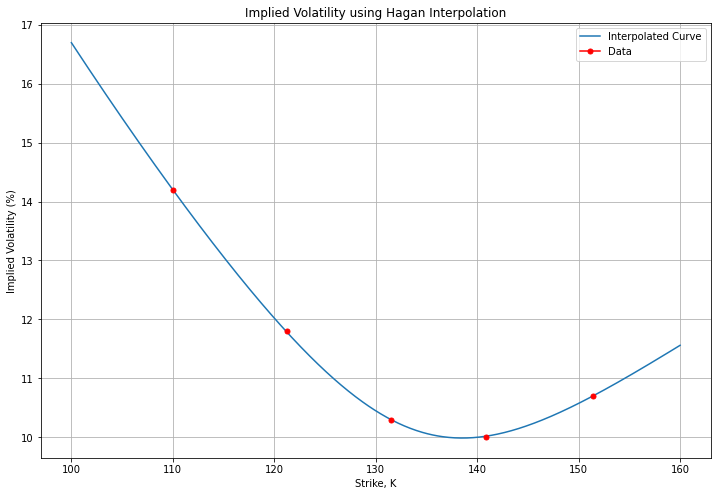

In [12]:
from scipy.optimize import minimize

initial_params = [0.5, 0.5, 0.5]  # alpha, rho, gamma

# ATM is K=131.5, which means S_F(t_0) = 131.5 (forward stock price)
strikes = np.array([110.0, 121.3, 131.5, 140.9, 151.4])
implied_vols = np.array([14.2, 11.8, 10.3, 10.0, 10.7]) / 100
S_forward = 131.5
T = 1

result = minimize(
    minimize_func,
    initial_params,
    method='nelder-mead',
    options={'xtol': 1e-11},
    args=(implied_vols, strikes, T, S_forward)
)

alpha, rho, gamma = result.x
beta = 0.5

# Plot for different strikes
Ks = np.arange(100, 160+0.1, 0.1)
ivs = HaganImpliedVolatility(Ks, 1, S_forward, alpha, beta, rho, gamma).sigma

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(Ks, ivs*100)
for k, vol in zip(strikes, implied_vols*100):
    plt.plot(k, vol, marker='o', markersize=5, color='red')
    
plt.legend(['Interpolated Curve', 'Data'])
plt.title('Implied Volatility using Hagan Interpolation')
plt.xlabel('Strike, K')
plt.ylabel('Implied Volatility (%)')
plt.grid()

In [1]:
def SABR_local_variance(x, t, s0, forward, alpha, beta, rho, gamma):
    dt = 0.001
    dx = 0.001
    
    sigma = lambda x, t: HaganImpliedVolatility(x, t, forward, alpha, beta, rho, gamma).sigma
    ds_dt = lambda x, t: (sigma(x, t+dt) - sigma(x, t)) / dt  # forward difference
    ds_dx = lambda x, t: (sigma(x+dx, t) - sigma(x-dx, t)) / (2 * dx)  # central difference
    d2s_dx2 = lambda x, t: (sigma(x+dx, t) - 2*sigma(x, t) + sigma(x-dx, t)) / (dx**2)
    
    w = lambda x, t: sigma(x, t) * sigma(x, t)*t
    dw_dt = lambda x, t: sigma(x, t)**2 + 2 * t * sigma(x, t) * ds_dt(x, t)
    dw_dx = lambda x, t: 2 * t * sigma(x, t) * ds_dx(x, t)
    d2w_dx2 = lambda x, t: 2 * t * ds_dx**2
    
    term1 = lambda x, t: dw_dt(x, t) + r

SyntaxError: invalid syntax (Temp/ipykernel_24316/4140831094.py, line 13)